## Align UMAPs from different timepoints (ATAC, RNA, and joint)
- Last updated: 4/12/2024
- Author: Yang-Joon Kim

### NOTES:
1. Let's start with the ATAC modality for now. We'll tackle the RNA and joint modalities later on.

### Overview:
- We are going to use a common PCA/LSI projection for all timepoints
- Compute the UMAPs independently 
- Find the k-nearest neighbors for each cluster in dataset t to dataset (t+1)
- Aligned UMAP should reflect the time-dependence of the dataset


### TO-DO:
- clean documentation on what is the required format for the input datasets

In [1]:
import pandas as pd 
import numpy as np 
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.neighbors import NearestNeighbors

import umap.aligned_umap
import sklearn.datasets

/tmp/ipykernel_1826275/1171018030.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the data

In [2]:
# export the PCs and metadata from the main object
multiome = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_counts_RNA.h5ad")
multiome

AnnData object with n_obs × n_vars = 95196 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'nCount_peaks_integrated', 'nFe

In [18]:
# Step 1: Remove fields containing "prediction"
multiome.obs = multiome.obs[[col for col in multiome.obs.columns if "prediction" not in col]]

# Step 2: Replace "." with "_" in field names
multiome.obs.columns = [col.replace(".", "_") for col in multiome.obs.columns]

multiome

AnnData object with n_obs × n_vars = 95196 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters'
    var: 'features'
    obsm: 'X_umap', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'

In [20]:
del multiome.raw

In [21]:
# save the object for excellxgene annotation
multiome.write_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_counts_RNA_formatted_excxg.h5ad")

### Load meta data

In [3]:
# import all - LSI, PCA, and metadata
metadata = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/metadata.csv", index_col=0)
integrated_lsi = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_lsi.csv", index_col=0)
integrated_pca = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_pca.csv", index_col=0)


In [8]:
metadata.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC',
       'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile',
       'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT',
       'global_annotation', 'prediction.score.Lateral_Mesoderm',
       'prediction.score.Neural_Crest', 'prediction.score.Somites',
       'prediction.score.Epidermal', 'prediction.score.Neural_Anterior',
       'prediction.score.Neural_Posterior', 'prediction.score.Endoderm',
       'prediction.score.PSM', 'prediction.score.Differentiating_Neurons',
       'prediction.score.Adaxial_Cells', 'prediction.score.NMPs',
       'prediction.score.Notochord', 'prediction.score.Muscle',
       'prediction.score.unassigned', 'prediction.score.max',
       'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype',
       'nFeature_peaks_celltype', 'nCount_peaks_merged',
       'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight',
       'nCount_Gene.Activity', 'nFeature_Ge

In [17]:
# Step 1: Remove columns containing "prediction"
metadata_filtered = metadata[[col for col in metadata.columns if "prediction" not in col]]

# Step 2: Replace "." with "-" in column names
metadata_filtered.columns = [col.replace(".", "_") for col in metadata_filtered.columns]

# Now, 'metadata_filtered' is your updated DataFrame
metadata_filtered.columns

Index(['orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC',
       'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile',
       'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT',
       'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk',
       'nCount_peaks_celltype', 'nFeature_peaks_celltype',
       'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight',
       'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity',
       'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset',
       'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8',
       'seurat_clusters', 'timepoint'],
      dtype='object')

In [10]:
metadata.dataset.unique()

array(['TDR118', 'TDR119', 'TDR124', 'TDR125', 'TDR126', 'TDR127',
       'TDR128'], dtype=object)

In [76]:
# create a dictionary to map the timepoints to each "dataset"
dict_timepoints = {"0somites":"TDR126",
                   "5somites":"TDR127",
                   "10somites":"TDR128",
                   "15somites":"TDR118",
                   "20somites":"TDR125",
                   "30somites":"TDR124",
                   "15somites-2":"TDR119"}

# Creating a reversed dictionary
reversed_dict_timepoints = {value: key for key, value in dict_timepoints.items()}

print(reversed_dict_timepoints)

{'TDR126': '0somites', 'TDR127': '5somites', 'TDR128': '10somites', 'TDR118': '15somites', 'TDR125': '20somites', 'TDR124': '30somites', 'TDR119': '15somites-2'}


In [112]:
metadata_filtered["timepoints"] = metadata_filtered.dataset.map(reversed_dict_timepoints)
metadata_filtered.head()

/tmp/ipykernel_1826275/1444894816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered["timepoints"] = metadata_filtered.dataset.map(reversed_dict_timepoints)


,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nCount_peaks_integrated,nFeature_peaks_integrated,dataset,integrated_weight,peaks_integrated_weight,wsnn_res_0_8,seurat_clusters,timepoint,manual_annotation,timepoints
AAACAGCCACCTAAGC-1_1,SeuratProject,6522,2317,21425,9781,0.571984,0.40,4.488213,0.48,5661,...,13987,11974,TDR118,4.062589e-01,0.593741,10,10,15somites,Epidermal,15somites
AAACAGCCAGGGAGGA-1_1,SeuratProject,6100,2319,10334,5028,0.448143,0.13,4.795205,0.75,5553,...,6889,6302,TDR118,7.616462e-01,0.238354,16,16,15somites,Lateral_Mesoderm,15somites
AAACAGCCATAGACCC-1_1,SeuratProject,12581,3467,51485,19874,0.514213,0.24,5.238692,0.92,5781,...,32040,23386,TDR118,5.938950e-08,1.000000,14,14,15somites,Neural_Posterior,15somites
AAACATGCAAACTCAT-1_1,SeuratProject,5642,2145,19812,9183,0.673319,0.85,4.409525,0.41,5363,...,13090,11254,TDR118,3.694048e-01,0.630595,0,0,15somites,Neural_Posterior,15somites
AAACATGCAAGGACCA-1_1,SeuratProject,2691,838,5182,2565,0.394904,0.06,4.939061,0.83,4727,...,3390,3149,TDR118,3.265597e-02,0.967344,3,3,15somites,Neural_Anterior,15somites


In [78]:
# define the timepointns to subset the metadata and lsi for individual timepoint
timepoints = ['0somites', '5somites', '10somites', '15somites', '20somites', '30somites']


In [79]:
# subset the metadata dataframe
meta_list = []
for timepoint in timepoints:
    df = metadata_filtered[metadata_filtered.timepoints==timepoint]
    meta_list.append(df)

In [80]:
# subset the lsi dataframe
lsi_list = []
lsi_df_list = []
n_lsis = 40

for timepoint in timepoints:
    # subset the metadata first, to use the indices for integrated_lsi subsetting (as they match)
    df_meta = metadata_filtered[metadata_filtered.timepoints==timepoint]
    # subset the integrated_lsi using the indices
    df_lsi = integrated_lsi[integrated_lsi.index.isin(df_meta.index)]
    
    # add the lsi list
    lsi_df_list.append(df_lsi)
    
    # extract the lsi components
    X = df_lsi.values
    # subset for 2:n_lsis components (we exclude the first LSI as it's usually correlated to the seq.depth)
    lsi_list.append(X[:,1:n_lsis])


Based on the distribution of distances we can select the top % of cells to use as anchors between the two datasets. 

In [32]:
for m in meta_list:
    print(m.shape)

(15036, 30)
(19138, 30)
(11038, 30)
(13614, 30)
(17273, 30)
(6610, 30)


In [43]:
for lsi in lsi_list: 
    print(lsi.shape)

(15036, 39)
(19138, 39)
(11038, 39)
(13614, 39)
(17273, 39)
(6610, 39)


Merge PCA projections

### Run Aligned UMAP

Create list of dictionaries 

In [45]:
anchor_dict = []
# # Parameter set 1: 
# max_k = 10
# frac_k = 0.05
# max_dist = 0.05
# use_metric = 'cosine'

# Parameter set 2: 
max_k = 20
frac_k = 0.05
max_dist = 0.05
use_metric = 'cosine'


for i in range(len(timepoints)-1):
    Y = lsi_list[i] # train on previous timepoint "progenitor space"
    X = lsi_list[i+1] # for cells in next timepoint predict "progenitors"
    
    nbrs = NearestNeighbors(n_neighbors=1, #algorithm='ball_tree',
                           metric = use_metric).fit(Y)
    
    distances, indices = nbrs.kneighbors(X) # predict top progenitor for all cells
    
    neigh_distribution = np.concatenate(distances, axis = 0)
    neigh_indexes = np.concatenate(indices, axis =0)
    
    pairs = pd.DataFrame( {'neighbor':neigh_indexes ,'dist':neigh_distribution})
    pairs.reset_index(inplace = True)
    pairs.rename(columns ={'index':'cell_target'},inplace=True)
    
    # Grup by cell type (we'll find top anchors for each cell type)
    pairs['cell_type'] = meta_list[i+1].global_annotation.values
    df1 = pairs.groupby(['cell_type'])

    df2 = df1.apply(lambda x: x.sort_values(["dist"]))

    df3=df2.reset_index(drop=True)

    # keep the top neighbors for each cell type (NOTE some cells in t+1 will map to many cells in t)
    
    # For each progenitor in t keep only the cell in (t+1) with the smallest distance
    # Closest relative
    pairs_rank = df3.groupby('neighbor').head(1)
    
    #pairs_rank = df3.groupby('cell_type').head(max_k)
    
    # For each cell type we keep the top k prgenitor relations 
    pairs_rank = pairs_rank.groupby('cell_type').head(max_k)
    
    # filter any neighbor pair with distance larger than threshold
    pairs_rank = pairs_rank[pairs_rank['dist']<max_dist] 
    
    
    pairs_dict = {pairs_rank['neighbor'].values[j] :pairs_rank['cell_target'].values[j]  for j in range(pairs_rank.shape[0])}
    
    
    anchor_dict.append(pairs_dict)

/tmp/ipykernel_1826275/868422618.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df1.apply(lambda x: x.sort_values(["dist"]))
/tmp/ipykernel_1826275/868422618.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df1.apply(lambda x: x.sort_values(["dist"]))
/tmp/ipykernel_1826275/868422618.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is de

In [46]:
len(pairs_dict)

220

In [52]:
aligned_mapper = umap.AlignedUMAP(metric="cosine",
                                    n_neighbors=20,
                                    alignment_regularisation=0.1, # strength of the anchors across timepoints, default 0.1
                                    alignment_window_size=3, # how far forward and backward across the datasets we look when doing alignment, defaut 5
                                    n_epochs=200,
                                    random_state=42,).fit(lsi_list, relations=anchor_dict)

/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/pyth

In [53]:
all_timepoints = []
for i in range(0,len(timepoints)):
    aligned_umap_coord = pd.DataFrame( {'UMAP_1':aligned_mapper.embeddings_[i].T[0], 'UMAP_2':aligned_mapper.embeddings_[i].T[1], 
                                        'timepoint' :timepoints[i], 
                                        'cell_type':meta_list[i]["global_annotation"].values, 
                                        'cell_id' : meta_list[i].index.to_list()})
    all_timepoints.append(aligned_umap_coord)
    
umap_coords = pd.concat(all_timepoints)

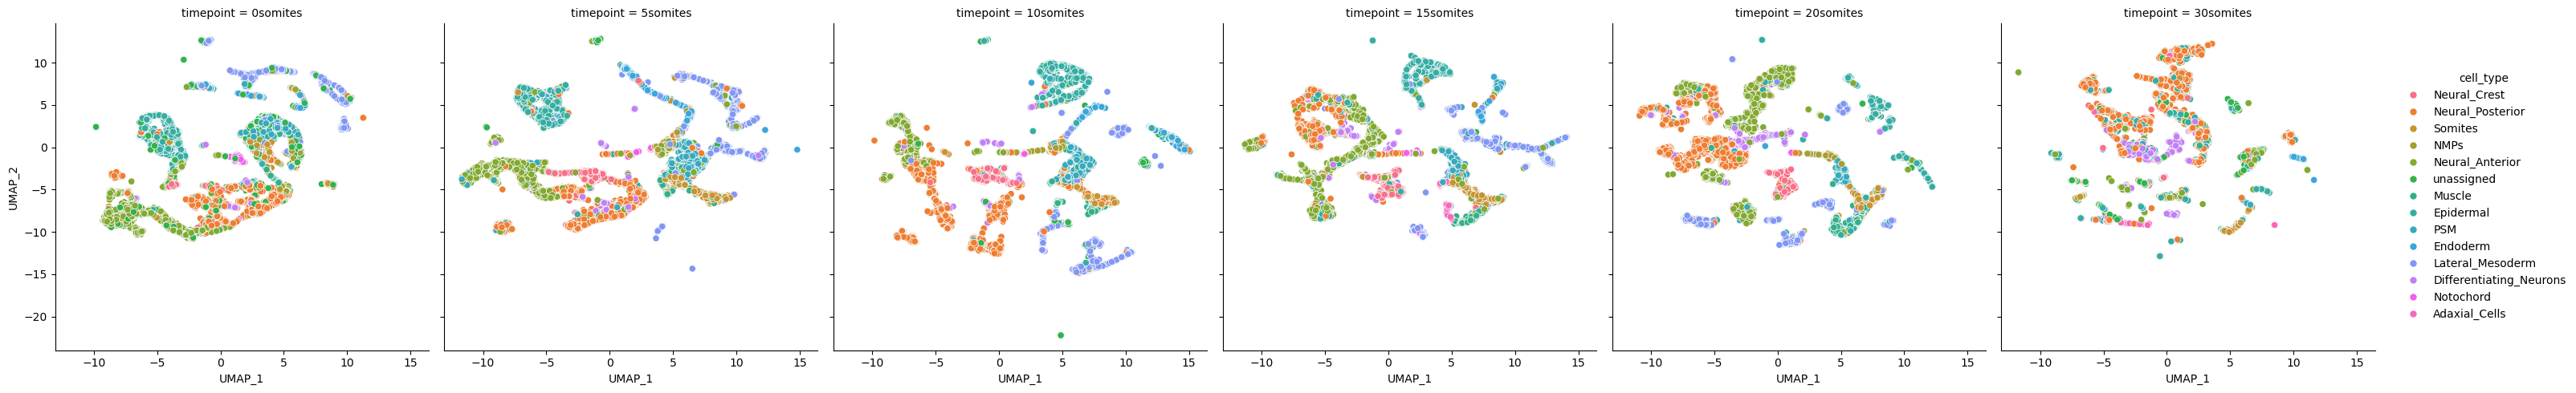

In [54]:
# alignment_regularisation=0.1
sns.relplot(
    data=umap_coords, x="UMAP_1", y="UMAP_2",
    col="timepoint", hue="cell_type",
    kind="scatter"
)

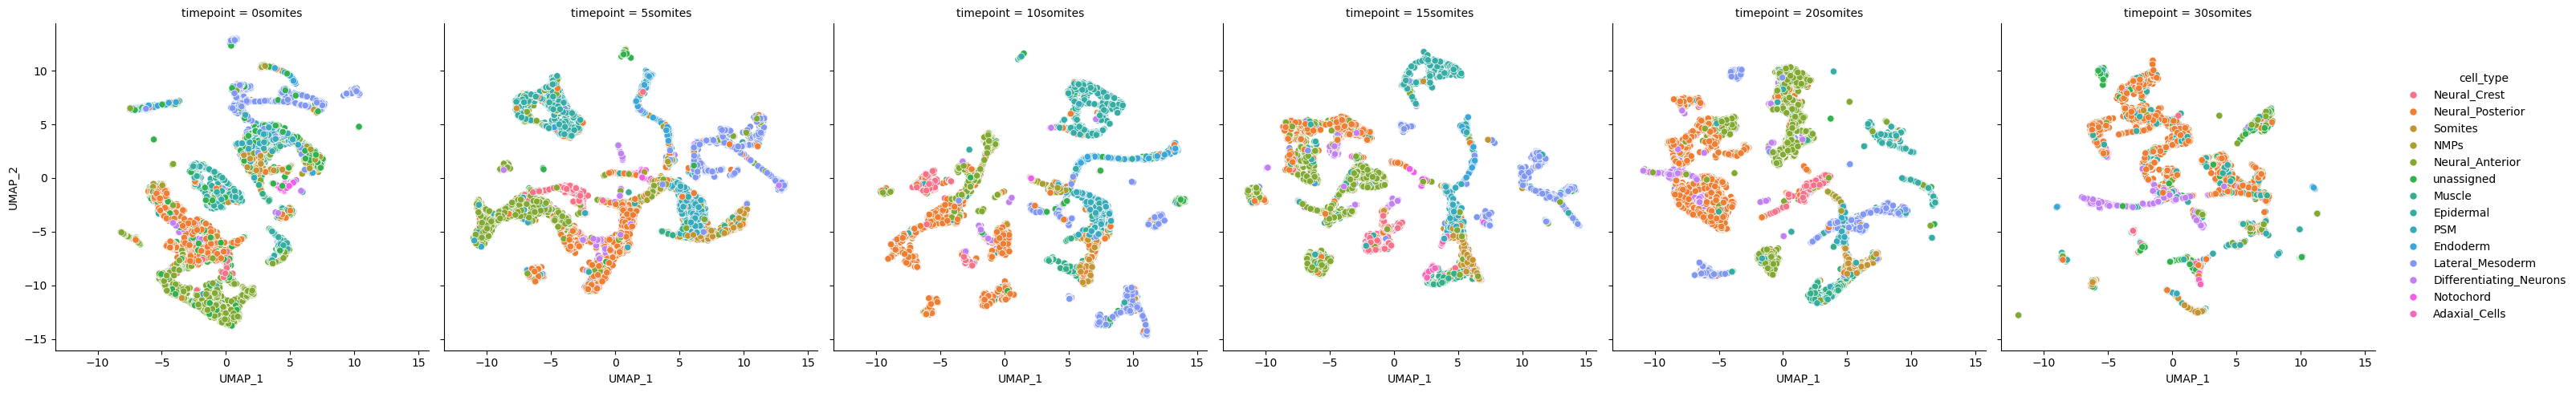

In [51]:
#alignment_regularisation=0.01
sns.relplot(
    data=umap_coords, x="UMAP_1", y="UMAP_2",
    col="timepoint", hue="cell_type",
    kind="scatter"
)

In [91]:
aligned_umap_coord.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/aligned_umap_coords.csv")

## Subset for the NMP trajectory population (the same celltypes used in Zebrahub Figure 6)


In [60]:
# Let's use some manual annotation for this - to see the best UMAP possible with the NMP population
annotation = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/celltype_annotation/multiome_annotation_04112024_v2.txt", index_col=0, sep="\t")
annotation.head()

,global_annotation,dataset,manual_annotation
AAACAGCCACCTAAGC-1_1,Epidermal,TDR118,Epidermal
AAACAGCCAGGGAGGA-1_1,Lateral_Mesoderm,TDR118,Lateral_Mesoderm
AAACAGCCATAGACCC-1_1,PSM,TDR118,Neural_Posterior
AAACATGCAAACTCAT-1_1,Neural_Posterior,TDR118,Neural_Posterior
AAACATGCAAGGACCA-1_1,Neural_Anterior,TDR118,Neural_Anterior


In [99]:
# add the "manual_annotation" category into the metadata df
metadata_filtered["manual_annotation"] = annotation.manual_annotation
metadata_filtered.head()

/tmp/ipykernel_1826275/1814956824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered["manual_annotation"] = annotation.manual_annotation


,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nFeature_Gene_Activity,nCount_peaks_integrated,nFeature_peaks_integrated,dataset,integrated_weight,peaks_integrated_weight,wsnn_res_0_8,seurat_clusters,timepoint,manual_annotation
AAACAGCCACCTAAGC-1_1,SeuratProject,6522,2317,21425,9781,0.571984,0.40,4.488213,0.48,5661,...,7106,13987,11974,TDR118,4.062589e-01,0.593741,10,10,15somites,Epidermal
AAACAGCCAGGGAGGA-1_1,SeuratProject,6100,2319,10334,5028,0.448143,0.13,4.795205,0.75,5553,...,4256,6889,6302,TDR118,7.616462e-01,0.238354,16,16,15somites,Lateral_Mesoderm
AAACAGCCATAGACCC-1_1,SeuratProject,12581,3467,51485,19874,0.514213,0.24,5.238692,0.92,5781,...,10345,32040,23386,TDR118,5.938950e-08,1.000000,14,14,15somites,Neural_Posterior
AAACATGCAAACTCAT-1_1,SeuratProject,5642,2145,19812,9183,0.673319,0.85,4.409525,0.41,5363,...,6534,13090,11254,TDR118,3.694048e-01,0.630595,0,0,15somites,Neural_Posterior
AAACATGCAAGGACCA-1_1,SeuratProject,2691,838,5182,2565,0.394904,0.06,4.939061,0.83,4727,...,2376,3390,3149,TDR118,3.265597e-02,0.967344,3,3,15somites,Neural_Anterior


In [113]:
# First, subset for the NMP trajectories - celltypes that are in Figure 6, zebrahub
celltypes_NMPs = ["NMPs", "PSM", "Somites", "Muscle",
                  "Neural_Anterior", "Neural_Posterior"]

# subset the metadata and lsi
metadata_NMPs = metadata_filtered[metadata_filtered.manual_annotation.isin(celltypes_NMPs)]
integrated_lsi_NMPs = integrated_lsi[metadata_filtered.manual_annotation.isin(celltypes_NMPs)]

In [116]:
# subset the metadata dataframe
meta_list = []
for timepoint in timepoints:
    df = metadata_NMPs[metadata_NMPs.timepoints==timepoint]
    meta_list.append(df)

In [74]:
timepoints

['0somites', '5somites', '10somites', '15somites', '20somites', '30somites']

In [117]:
metadata_NMPs.timepoints.unique()

array(['15somites', '15somites-2', '30somites', '20somites', '0somites',
       '5somites', '10somites'], dtype=object)

In [118]:
# subset the lsi dataframe
lsi_list = []
lsi_df_list = []
n_lsis = 40

for timepoint in timepoints:
    # subset the metadata first, to use the indices for integrated_lsi subsetting (as they match)
    df_meta = metadata_NMPs[metadata_NMPs.timepoints==timepoint]
    # subset the integrated_lsi using the indices
    df_lsi = integrated_lsi_NMPs[integrated_lsi_NMPs.index.isin(df_meta.index)]
    
    # add the lsi list
    lsi_df_list.append(df_lsi)
    
    # extract the lsi components
    X = df_lsi.values
    # subset for 2:n_lsis components (we exclude the first LSI as it's usually correlated to the seq.depth)
    lsi_list.append(X[:,1:n_lsis])


Based on the distribution of distances we can select the top % of cells to use as anchors between the two datasets. 

In [119]:
for m in meta_list:
    print(m.shape)

(9157, 32)
(11271, 32)
(5800, 32)
(8237, 32)
(11824, 32)
(5002, 32)


In [120]:
for lsi in lsi_list: 
    print(lsi.shape)

(9157, 39)
(11271, 39)
(5800, 39)
(8237, 39)
(11824, 39)
(5002, 39)


Merge PCA projections

### Run Aligned UMAP

Create list of dictionaries 

In [124]:
anchor_dict = []
# # Parameter set 1: 
# max_k = 10
# frac_k = 0.05
# max_dist = 0.05
# use_metric = 'cosine'

# Parameter set 2: 
max_k = 20
frac_k = 0.05
max_dist = 0.05
use_metric = 'cosine'


for i in range(len(timepoints)-1):
    Y = lsi_list[i] # train on previous timepoint "progenitor space"
    X = lsi_list[i+1] # for cells in next timepoint predict "progenitors"
    
    nbrs = NearestNeighbors(n_neighbors=1, #algorithm='ball_tree',
                           metric = use_metric).fit(Y)
    
    distances, indices = nbrs.kneighbors(X) # predict top progenitor for all cells
    
    neigh_distribution = np.concatenate(distances, axis = 0)
    neigh_indexes = np.concatenate(indices, axis =0)
    
    pairs = pd.DataFrame( {'neighbor':neigh_indexes ,'dist':neigh_distribution})
    pairs.reset_index(inplace = True)
    pairs.rename(columns ={'index':'cell_target'},inplace=True)
    
    # Grup by cell type (we'll find top anchors for each cell type)
    pairs['cell_type'] = meta_list[i+1].manual_annotation.values
    df1 = pairs.groupby(['cell_type'])

    df2 = df1.apply(lambda x: x.sort_values(["dist"]))

    df3=df2.reset_index(drop=True)

    # keep the top neighbors for each cell type (NOTE some cells in t+1 will map to many cells in t)
    
    # For each progenitor in t keep only the cell in (t+1) with the smallest distance
    # Closest relative
    pairs_rank = df3.groupby('neighbor').head(1)
    
    #pairs_rank = df3.groupby('cell_type').head(max_k)
    
    # For each cell type we keep the top k prgenitor relations 
    pairs_rank = pairs_rank.groupby('cell_type').head(max_k)
    
    # filter any neighbor pair with distance larger than threshold
    pairs_rank = pairs_rank[pairs_rank['dist']<max_dist] 
    
    
    pairs_dict = {pairs_rank['neighbor'].values[j] :pairs_rank['cell_target'].values[j]  for j in range(pairs_rank.shape[0])}
    
    
    anchor_dict.append(pairs_dict)

/tmp/ipykernel_1826275/946888747.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df1.apply(lambda x: x.sort_values(["dist"]))
/tmp/ipykernel_1826275/946888747.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df1.apply(lambda x: x.sort_values(["dist"]))
/tmp/ipykernel_1826275/946888747.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is de

In [125]:
len(pairs_dict)

88

In [126]:
aligned_mapper = umap.AlignedUMAP(metric="cosine",
                                    n_neighbors=20,
                                    alignment_regularisation=0.1, # strength of the anchors across timepoints, default 0.1
                                    alignment_window_size=3, # how far forward and backward across the datasets we look when doing alignment, defaut 5
                                    n_epochs=200,
                                    random_state=42,).fit(lsi_list, relations=anchor_dict)

/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/pyth

In [127]:
all_timepoints = []
for i in range(0,len(timepoints)):
    aligned_umap_coord = pd.DataFrame( {'UMAP_1':aligned_mapper.embeddings_[i].T[0], 'UMAP_2':aligned_mapper.embeddings_[i].T[1], 
                                        'timepoint' :timepoints[i], 
                                        'cell_type':meta_list[i]["manual_annotation"].values, 
                                        'cell_id' : meta_list[i].index.to_list()})
    all_timepoints.append(aligned_umap_coord)
    
umap_coords = pd.concat(all_timepoints)

In [144]:
import os

In [145]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/aligned_umaps/"
os.makedirs(figpath, exist_ok=True)

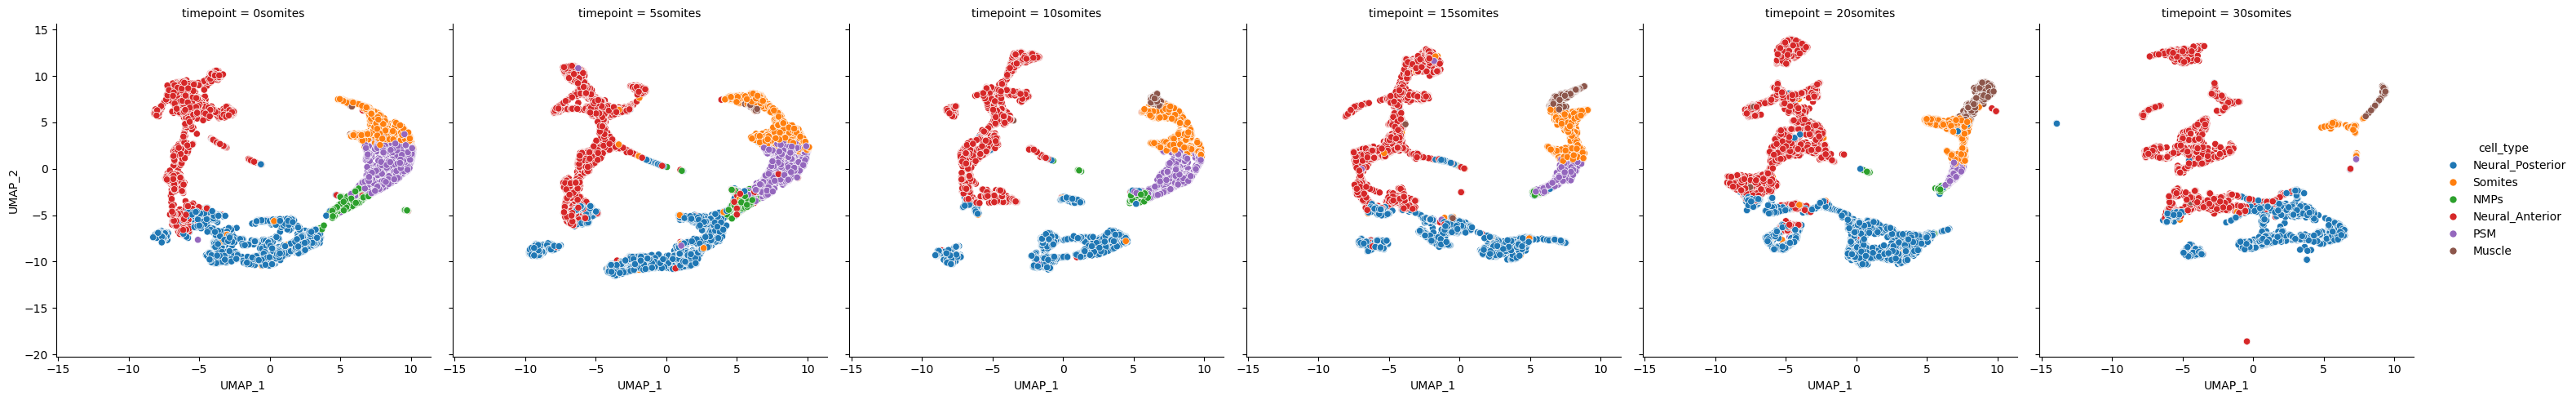

In [146]:
sns.relplot(
    data=umap_coords, x="UMAP_1", y="UMAP_2",
    col="timepoint", hue="cell_type",
    kind="scatter"
)

plt.savefig(figpath + "aligned_umap_NMPs_timepoints.png")
plt.savefig(figpath + "aligned_umap_NMPs_timepoints.pdf")

Load meta data

### These UMAPs do look better! Now, let's see how many NMP cells are there at each timepoint


In [147]:
# save the aligned_umap coordinates for all timepoints (note that TDR119reseq was excluded)
umap_coords.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/aligned_umap_coords_NMPs.csv")

## Subsetting the alignedUMAP coordinates to each timepoint adata

In [148]:
aligned_umap_coords = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/aligned_umap_coords_NMPs.csv", index_col=0)
aligned_umap_coords

,UMAP_1,UMAP_2,timepoint,cell_type,cell_id
0,1.070022,-6.046746,0somites,Neural_Posterior,AAACAGCCAAACGGGC-1_5
1,2.922442,-6.883583,0somites,Neural_Posterior,AAACAGCCAACACTTG-1_5
2,8.178947,5.224598,0somites,Somites,AAACAGCCACAATGCC-1_5
3,-4.169683,-9.929869,0somites,Neural_Posterior,AAACAGCCACCTGGTG-1_5
4,5.393727,-3.432797,0somites,NMPs,AAACAGCCAGTTATCG-1_5
...,...,...,...,...,...
4997,-2.765761,-3.246945,30somites,Neural_Anterior,TTTGTGAAGGGTGAGT-1_3
4998,-3.209528,1.374542,30somites,Neural_Anterior,TTTGTGAAGTTCCCAC-1_3
4999,8.365387,6.309262,30somites,Muscle,TTTGTGGCATAGCGGA-1_3
5000,6.254581,-7.140865,30somites,Neural_Posterior,TTTGTGTTCATCAGTA-1_3


In [6]:
# import the h5ad object for all cells across all timepoints
multiome = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_counts_RNA.h5ad")
multiome

/hpc/user_apps/data.science/conda_envs/single-cell-basics/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 4117 × 2000
    obs: 'seurat_clusters_res1.5', 'seqrun', 'leiden_v6_r0.32', 'leiden_v5_r0.35', 'annotation_seuratres1_5_v3', 'integrated_snn_res.0.5', 'orig.ident', 'fish_n', 'global_annotation', 'leiden_v11_r0.22', 'leiden_v4_r0.3', 'leiden_v3_r0.2', 'leiden_v10_r0.25', 'cell_annotation', 'fish', 'seurat_clusters', 'leiden_v2_r0.5', 'leiden_v12_r0.23', 'annotation_umapv2', 'annotation_umapv2_recluster', 'timepoint', 'leiden_v1_r1', 'leiden_v8_r0.31', 'X10X_run', 'annotation_umapv2_global', 'leiden_v9_r0.31', 'leiden_v7_r0.3', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [151]:
# First, subset the dataset into multiome 
multiome_NMPs = multiome[multiome.obs_names.isin(aligned_umap_coords.cell_id)]
multiome_NMPs

View of AnnData object with n_obs × n_vars = 51291 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters'
    var: 'features'
    obsm: 'X_umap', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'

In [9]:
# transfer the UMAP, PCA, neighbors, and distances from the adata(seurat integrated) object to the adata_filtered
# copy over the dim.reductions

# Convert to DataFrame for alignment
df_umap = pd.DataFrame(adata.obsm["X_umap"], index=adata.obs.index)
df_pca = pd.DataFrame(adata.obsm["X_pca"], index=adata.obs.index)

# Reindex this DataFrame to match adata_filtered
adata_filtered.obsm['X_umap'] = df_umap.loc[adata_filtered.obs.index].values
adata_filtered.obsm['X_pca'] = df_pca.loc[adata_filtered.obs.index].values

# re-compute the nearest neighbors
sc.pp.neighbors(adata_filtered, n_neighbors=15, n_pcs=30)
adata_filtered

# adata_filtered.obsm["X_umap"] = adata.obsm["X_umap"]
# adata_filtered.obsm["X_pca"] = adata.obsm["X_pca"]
# adata_filtered.uns["neighbors"] = adata.uns["neighbors"]
# adata_filtered.obsp["distances"] = adata.obsp["distances"]

AnnData object with n_obs × n_vars = 4117 × 26065
    obs: 'seurat_clusters_res1.5', 'seqrun', 'leiden_v6_r0.32', 'leiden_v5_r0.35', 'annotation_seuratres1_5_v3', 'integrated_snn_res.0.5', 'orig.ident', 'fish_n', 'global_annotation', 'leiden_v11_r0.22', 'leiden_v4_r0.3', 'leiden_v3_r0.2', 'leiden_v10_r0.25', 'cell_annotation', 'fish', 'seurat_clusters', 'leiden_v2_r0.5', 'leiden_v12_r0.23', 'annotation_umapv2', 'annotation_umapv2_recluster', 'timepoint', 'leiden_v1_r1', 'leiden_v8_r0.31', 'X10X_run', 'annotation_umapv2_global', 'leiden_v9_r0.31', 'leiden_v7_r0.3', 'leiden'
    var: 'mean', 'variance', 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'std'
    uns: 'annotation_seuratres1_5_v3_colors', 'annotation_umapv2_colors', 'fish_colors', 'global_annotation_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_654d8b39', 'X_umap_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'd

Double check that number make sense (we should have all cells with new UMAP coordinates) 

## Aligned UMAP for WNN (weighted nearest neighbor from RNA and ATAC modalities - Seurat.v4 recipe)

- 

In [154]:
multiome

AnnData object with n_obs × n_vars = 95196 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters'
    var: 'features'
    obsm: 'X_umap', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'

In [152]:
# subset the metadata dataframe
meta_list = []
for timepoint in timepoints:
    df = metadata_filtered[metadata_filtered.timepoints==timepoint]
    meta_list.append(df)

In [160]:
multiome.obsm["X_wnn.umap"]

wnn_umap = pd.DataFrame(index=multiome.obs_names, columns=["X_umap1"])

array([[ -1.51338325, -11.30033358],
       [ 10.37701334,   7.06515209],
       [ -4.10516916,   5.28862993],
       ...,
       [ -0.66839652,   1.62835221],
       [  9.09235396,  -7.50639923],
       [  3.58865871,   6.0117325 ]])

In [80]:
# # subset the lsi dataframe
# wnn_list = []
# wnn_df_list = []
# n_lsis = 40

# for timepoint in timepoints:
#     # subset the metadata first, to use the indices for integrated_lsi subsetting (as they match)
#     df_meta = metadata_filtered[metadata_filtered.timepoints==timepoint]
#     # subset the integrated_lsi using the indices
#     df_lsi = integrated_lsi[integrated_lsi.index.isin(df_meta.index)]
    
#     # add the lsi list
#     lsi_df_list.append(df_lsi)
    
#     # extract the lsi components
#     X = df_lsi.values
#     # subset for 2:n_lsis components (we exclude the first LSI as it's usually correlated to the seq.depth)
#     lsi_list.append(X[:,1:n_lsis])


In [ ]:
anchor_dict = []

# Parameter Configuration
max_k = 20
max_dist = 0.05

for i in range(len(timepoints)-1):
    # Assuming 'wnn_neighbors' is a list of DataFrames or similar structures where
    # each DataFrame corresponds to weighted nearest neighbors for that timepoint
    # Each DataFrame should have columns for 'neighbor_index' and 'distance'
    
    current_neighbors = wnn_neighbors[i]
    
    # Filter to keep only neighbors within the max distance
    valid_neighbors = current_neighbors[current_neighbors['distance'] < max_dist]
    
    # If the neighbors are sorted by distance already, we can simply group by cell type and take the top k entries
    # Ensure that 'cell_type' is available in the metadata
    valid_neighbors['cell_type'] = meta_list[i+1].global_annotation.values  # Adjust index as needed if meta_list indexing differs
    
    # Group by cell type and select the closest k neighbors
    grouped = valid_neighbors.groupby('cell_type').apply(lambda x: x.nsmallest(max_k, 'distance')).reset_index(drop=True)
    
    # For each cell type, keep only the closest neighbor (smallest distance) for each unique target cell in t+1
    closest_per_type = grouped.groupby(['cell_type', 'cell_target']).first().reset_index()
    
    # Extract pairs for the anchor dictionary
    for cell_type, group in closest_per_type.groupby('cell_type'):
        anchors = group.set_index('neighbor_index')['cell_target'].to_dict()
        anchor_dict.append(anchors)

Based on the distribution of distances we can select the top % of cells to use as anchors between the two datasets. 

In [153]:
for m in meta_list:
    print(m.shape)

(15036, 32)
(19138, 32)
(11038, 32)
(13614, 32)
(17273, 32)
(6610, 32)


In [43]:
for lsi in lsi_list: 
    print(lsi.shape)

(15036, 39)
(19138, 39)
(11038, 39)
(13614, 39)
(17273, 39)
(6610, 39)


Merge PCA projections

### Run Aligned UMAP

Create list of dictionaries 

In [45]:
anchor_dict = []
# # Parameter set 1: 
# max_k = 10
# frac_k = 0.05
# max_dist = 0.05
# use_metric = 'cosine'

# Parameter set 2: 
max_k = 20
frac_k = 0.05
max_dist = 0.05
use_metric = 'cosine'


for i in range(len(timepoints)-1):
    Y = lsi_list[i] # train on previous timepoint "progenitor space"
    X = lsi_list[i+1] # for cells in next timepoint predict "progenitors"
    
    nbrs = NearestNeighbors(n_neighbors=1, #algorithm='ball_tree',
                           metric = use_metric).fit(Y)
    
    distances, indices = nbrs.kneighbors(X) # predict top progenitor for all cells
    
    neigh_distribution = np.concatenate(distances, axis = 0)
    neigh_indexes = np.concatenate(indices, axis =0)
    
    pairs = pd.DataFrame( {'neighbor':neigh_indexes ,'dist':neigh_distribution})
    pairs.reset_index(inplace = True)
    pairs.rename(columns ={'index':'cell_target'},inplace=True)
    
    # Group by cell type (we'll find top anchors for each cell type)
    pairs['cell_type'] = meta_list[i+1].global_annotation.values
    df1 = pairs.groupby(['cell_type'])

    df2 = df1.apply(lambda x: x.sort_values(["dist"]))

    df3=df2.reset_index(drop=True)

    # keep the top neighbors for each cell type (NOTE some cells in t+1 will map to many cells in t)
    
    # For each progenitor in t keep only the cell in (t+1) with the smallest distance
    # Closest relative
    pairs_rank = df3.groupby('neighbor').head(1)
    
    #pairs_rank = df3.groupby('cell_type').head(max_k)
    
    # For each cell type we keep the top k prgenitor relations 
    pairs_rank = pairs_rank.groupby('cell_type').head(max_k)
    
    # filter any neighbor pair with distance larger than threshold
    pairs_rank = pairs_rank[pairs_rank['dist']<max_dist] 
    
    
    pairs_dict = {pairs_rank['neighbor'].values[j] :pairs_rank['cell_target'].values[j]  for j in range(pairs_rank.shape[0])}
    
    
    anchor_dict.append(pairs_dict)

/tmp/ipykernel_1826275/868422618.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df1.apply(lambda x: x.sort_values(["dist"]))
/tmp/ipykernel_1826275/868422618.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df1.apply(lambda x: x.sort_values(["dist"]))
/tmp/ipykernel_1826275/868422618.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is de

In [46]:
len(pairs_dict)

220

In [52]:
aligned_mapper = umap.AlignedUMAP(metric="cosine",
                                    n_neighbors=20,
                                    alignment_regularisation=0.1, # strength of the anchors across timepoints, default 0.1
                                    alignment_window_size=3, # how far forward and backward across the datasets we look when doing alignment, defaut 5
                                    n_epochs=200,
                                    random_state=42,).fit(lsi_list, relations=anchor_dict)

/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/pyth

In [53]:
all_timepoints = []
for i in range(0,len(timepoints)):
    aligned_umap_coord = pd.DataFrame( {'UMAP_1':aligned_mapper.embeddings_[i].T[0], 'UMAP_2':aligned_mapper.embeddings_[i].T[1], 
                                        'timepoint' :timepoints[i], 
                                        'cell_type':meta_list[i]["global_annotation"].values, 
                                        'cell_id' : meta_list[i].index.to_list()})
    all_timepoints.append(aligned_umap_coord)
    
umap_coords = pd.concat(all_timepoints)

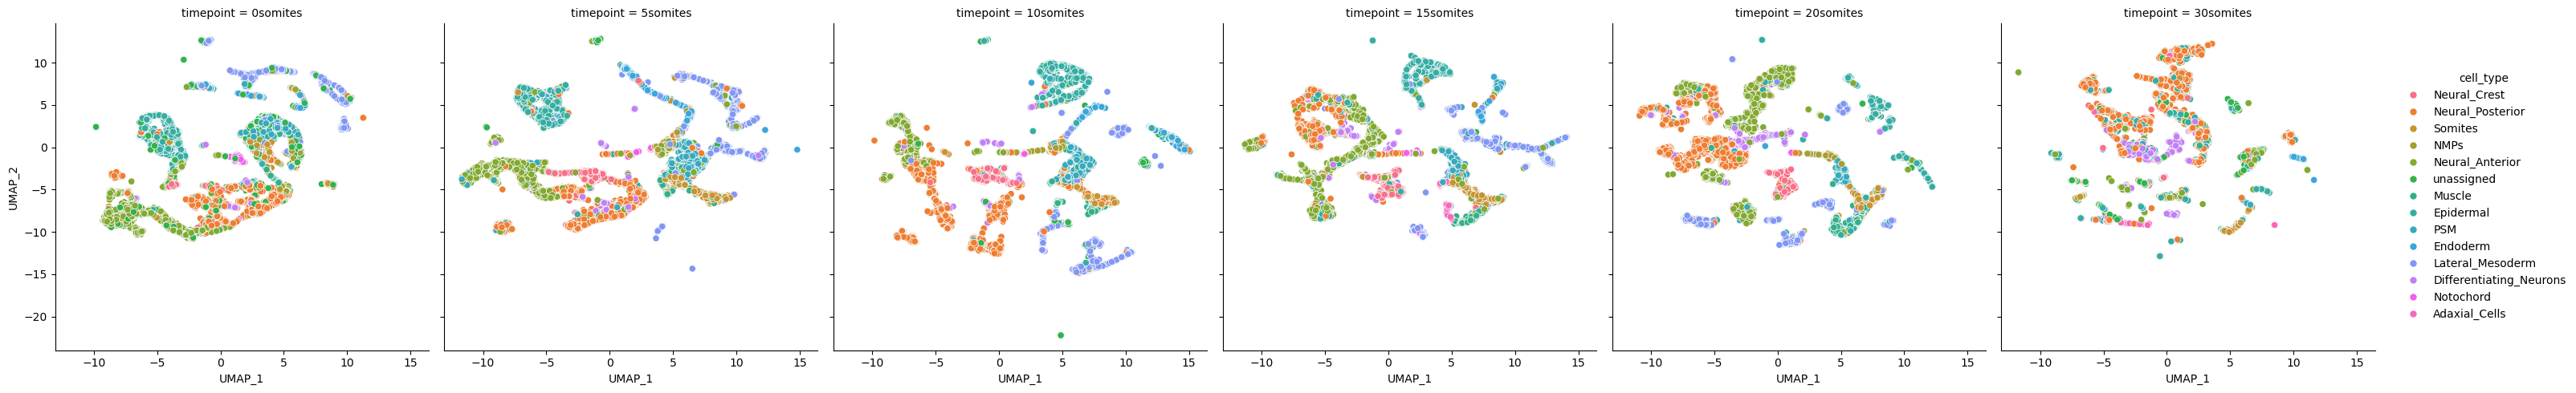

In [54]:
# alignment_regularisation=0.1
sns.relplot(
    data=umap_coords, x="UMAP_1", y="UMAP_2",
    col="timepoint", hue="cell_type",
    kind="scatter"
)

Apr 14th 2022

* First subset those cells with aligned UMAP coordinates 
* Replace scanpy UMAP with aligned UMAP 
* Export h5ad into a different directory